In [3]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(1, '/home/georgeos/Documents/GitHub/SyMBac/') # Not needed if you installed SyMBac using pip
sys.path.insert(1, '/home/georgeos/Documents/Github/SyMBac/') # Not needed if you installed SyMBac using pip

import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
from PIL import Image
from skimage.util import img_as_uint
import os
import zarr
from numcodecs import Blosc
from joblib import Parallel, delayed
from glob import glob
from SyMBac.colony_renderer import ColonyRenderer
import noise
from skimage.filters import threshold_otsu
from skimage.transform import rescale, resize, downscale_local_mean
from scipy.signal import find_peaks
import pandas as pd
from scipy.ndimage import binary_fill_holes
import seaborn as sns
from natsort import natsorted
from sklearn.metrics import jaccard_score
from matplotlib import cm, colors as mcolors
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition
import matplotlib
import scienceplots

plt.style.use(['science','nature', "no-latex"])

matplotlib.rcParams["xtick.minor.bottom"]=False
matplotlib.rcParams["xtick.top"]=False
matplotlib.rcParams["ytick.minor.left"]=False
matplotlib.rcParams["ytick.right"]=False
matplotlib.rcParams["font.size"] = 6
matplotlib.rcParams["axes.labelpad"] = 0

In [4]:
resize_amount = 1
pix_mic_conv = 0.065 / 17

all_data = pd.read_pickle("all_data.pickle")

wavelength_colours = ["k", "b", "g", "orange", "r"] 

standard_cell = all_data.query("`True Width` == 1.04")

In [5]:
matplotlib.rcParams["xtick.minor.bottom"]=False
matplotlib.rcParams["xtick.top"]=False
matplotlib.rcParams["ytick.minor.left"]=False
matplotlib.rcParams["ytick.right"]=False
matplotlib.rcParams["font.size"] = 6
matplotlib.rcParams["axes.labelpad"] = 0

In [6]:
global_ylims = 0.65, 1.1

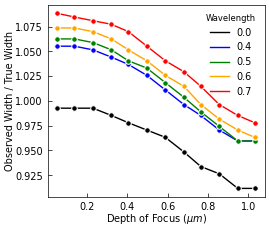

In [11]:
plt.figure(figsize=(2.8,2.5))
sns.lineplot(x="Depth of Focus", y="Observed Width / True Width", hue = "Wavelength",
     data=standard_cell.query("`Imaging Modality` == 'FL'"), palette=wavelength_colours, marker= "o", markersize=4)
#plt.title("Width = 1, Imaging Modality = FL")
plt.xlabel("Depth of Focus ($\mu m$)")
plt.savefig("FL_wavelength.pdf")

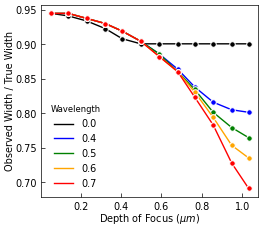

In [12]:
plt.figure(figsize=(2.8,2.5))
sns.lineplot(x="Depth of Focus", y="Observed Width / True Width", hue = "Wavelength",
     data=standard_cell.query("`Imaging Modality` == 'membrane'"), palette=wavelength_colours, marker= "o", markersize=4)
#plt.title("Width = 1, Imaging Modality = Membrane")
plt.xlabel("Depth of Focus ($\mu m$)")
plt.savefig("membrane_wavelength.pdf")

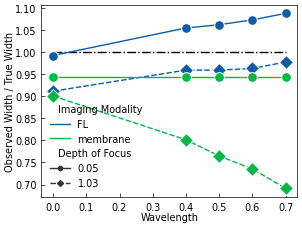

In [13]:
max_dof_FL = standard_cell.query("`Imaging Modality` == 'FL'")["Depth of Focus"].max()
min_dof_FL = standard_cell.query("`Imaging Modality` == 'FL'")["Depth of Focus"].min()
high_dof_wavelength_FL = standard_cell.query("`Imaging Modality` == 'FL' & `Depth of Focus` == @max_dof_FL").drop(columns = ["profile", "x axis", "ID", "filename"]).drop_duplicates()
low_dof_wavelength_FL = standard_cell.query("`Imaging Modality` == 'FL' & `Depth of Focus` == @min_dof_FL").drop(columns = ["profile", "x axis", "ID", "filename"]).drop_duplicates()

max_dof_membrane = standard_cell.query("`Imaging Modality` == 'membrane'")["Depth of Focus"].max()
min_dof_membrane = standard_cell.query("`Imaging Modality` == 'membrane'")["Depth of Focus"].min()
high_dof_wavelength_membrane = standard_cell.query("`Imaging Modality` == 'membrane' & `Depth of Focus` == @max_dof_membrane").drop(columns = ["profile", "x axis", "ID", "filename"]).drop_duplicates()
low_dof_wavelength_membrane = standard_cell.query("`Imaging Modality` == 'membrane' & `Depth of Focus` == @min_dof_membrane").drop(columns = ["profile", "x axis", "ID", "filename"]).drop_duplicates()



high_low_dof = pd.concat([high_dof_wavelength_FL, low_dof_wavelength_FL, high_dof_wavelength_membrane, low_dof_wavelength_membrane])
plt.plot([0,0.7],[1,1], c="k", linestyle="-.")
p = sns.lineplot(x = "Wavelength", y = "Observed Width / True Width", data = high_low_dof, style = "Depth of Focus", hue = "Imaging Modality", markers = ["o", "D"], markersize=7,)
leg = p.legend_
for t in leg.texts:
    if any([x in t.get_text() for x in ["Imag", "FL", "memb", "Depth"]]):
        pass
    else:
    # truncate label text to 4 characters
        t.set_text(t.get_text()[:4])

plt.savefig("wavelength.pdf")

In [14]:
high_low_dof = pd.concat([high_dof_wavelength_FL, low_dof_wavelength_FL, high_dof_wavelength_membrane, low_dof_wavelength_membrane])
imshow_data = all_data.loc[high_low_dof.index]

In [15]:
from matplotlib_scalebar.scalebar import ScaleBar


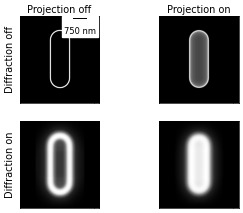

<Figure size 330x250 with 0 Axes>

In [16]:
##00 = proj, diff
def membrane_imshow(into_subplot = False, axs = None):
    
    if not into_subplot:
        fig, axs = plt.subplots(2,2)
        mem_00, mem_10, mem_01, mem_11 = axs.flatten()
    else:
        mem_00, mem_10, mem_01, mem_11 = axs
    


    mem_00.imshow( np.load(imshow_data.query("`Imaging Modality` == 'membrane' & Wavelength == 0 & `Depth of Focus` == @min_dof_membrane")["filename"].iloc[0])[200:-200,:], cmap="Greys_r" )

    mem_10.imshow( np.load(imshow_data.query("`Imaging Modality` == 'membrane' & Wavelength == 0 & `Depth of Focus` == @max_dof_membrane")["filename"].iloc[0])[200:-200,:], cmap="Greys_r" )

    mem_01.imshow( np.load(imshow_data.query("`Imaging Modality` == 'membrane' & Wavelength == 0.7 & `Depth of Focus` == @min_dof_membrane")["filename"].iloc[0])[200:-200,:], cmap="Greys_r" )

    mem_11.imshow( np.load(imshow_data.query("`Imaging Modality` == 'membrane' & Wavelength == 0.7 & `Depth of Focus` == @max_dof_membrane")["filename"].iloc[0])[200:-200,:], cmap="Greys_r" )

    
    for ax in [mem_00, mem_10, mem_01, mem_11]:
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        
    mem_00.set_xlabel('Projection off',labelpad=2)    
    mem_00.xaxis.set_label_position('top') 
    mem_00.set_ylabel("Diffraction off")
    
    mem_10.set_xlabel("Projection on",labelpad=2)
    mem_10.xaxis.set_label_position('top') 
    
    mem_01.set_ylabel("Diffraction on")
    
    scalebar = ScaleBar(pix_mic_conv, "um")
    mem_00.add_artist(scalebar)

    if not into_subplot:
        plt.show()
        plt.savefig("membrane_imshow.pdf")
        
membrane_imshow()

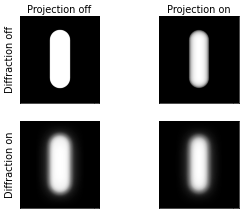

In [92]:
##00 = proj, diff
def FL_imshow(into_subplot = False, axs = None):
    if not into_subplot:
        fig, axs = plt.subplots(2,2)
        FL_00, FL_10, FL_01, FL_11 = axs.flatten()
    else:
        FL_00, FL_10, FL_01, FL_11 = axs
    

    FL_00.imshow(  np.load(imshow_data.query("`Imaging Modality` == 'FL' & Wavelength == 0 & `Depth of Focus` == @min_dof_membrane")["filename"].iloc[0])[200:-200,:], cmap="Greys_r" )

    FL_10.imshow(  np.load(imshow_data.query("`Imaging Modality` == 'FL' & Wavelength == 0 & `Depth of Focus` == @max_dof_membrane")["filename"].iloc[0])[200:-200,:], cmap="Greys_r" )

    FL_01.imshow(  np.load(imshow_data.query("`Imaging Modality` == 'FL' & Wavelength == 0.7 & `Depth of Focus` == @min_dof_membrane")["filename"].iloc[0])[200:-200,:], cmap="Greys_r" )

    FL_11.imshow(  np.load(imshow_data.query("`Imaging Modality` == 'FL' & Wavelength == 0.7 & `Depth of Focus` == @max_dof_membrane")["filename"].iloc[0])[200:-200,:], cmap="Greys_r" )

    for ax in [FL_00, FL_10, FL_01, FL_11]:
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        
    FL_00.set_xlabel('Projection off',labelpad=2)
    FL_00.xaxis.set_label_position('top') 
    FL_00.set_ylabel("Diffraction off")
    
    FL_10.set_xlabel("Projection on",labelpad=2)
    FL_10.xaxis.set_label_position('top') 
    
    FL_01.set_ylabel("Diffraction on")
    

    
    #plt.tight_layout()
    if not into_subplot:
        plt.show()

FL_imshow()


In [18]:
profiles = []
for index, row in imshow_data.iterrows():
    profiles.append(row["profile"])

max_int = np.max(profiles)
#profiles[0] = profiles[0]/profiles[0].max() * max_int

profiles = [x/x.max() * max_int for x in profiles]

x_axes = []
for plot_profile in profiles:
    x_axis = np.arange(0,len(plot_profile),1).astype(float)
    x_axis -= x_axis.max()/2
    x_axis *= pix_mic_conv
    x_axes.append(x_axis)

imshow_data["profile"] = profiles
imshow_data["x axis"] = x_axes
imshow_data = imshow_data.explode(["profile", "x axis"])

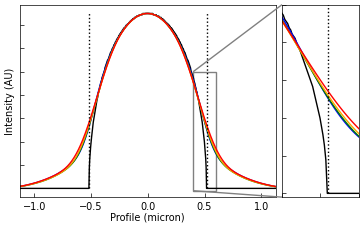

In [20]:

def FL_profile_plot(into_subplot = False, ax = None):
    if not into_subplot:
        fig, ax = plt.subplots(1,1)
    sns.lineplot(x="x axis", y="profile", hue = "Wavelength",
                         data=imshow_data.query("`Imaging Modality` == 'FL' & `Depth of Focus` == @max_dof_membrane"), palette=wavelength_colours, ax = ax, legend = None)
    width = imshow_data["True Width"].unique()[0]

    axins1 = inset_axes(ax, 0.5 ,0.5, "upper left",) #zoomed_inset_axes(ax, 5, loc="lower center", bbox_to_anchor=(10,-100))

    mark_inset(ax, axins1, loc1=3, loc2=2, fc="none", ec="0.5")
    sns.lineplot(x="x axis", y="profile", hue = "Wavelength",
                         data=imshow_data.query("`Imaging Modality` == 'FL' & `Depth of Focus` == @max_dof_membrane"), palette=wavelength_colours, ax = axins1, legend=None)
    axins1.set_xlim([0.4,0.6])
    axins1.set_ylim([-0.1*10**5, 5.*10**5])
    axins1.set_xlabel(None)
    axins1.set_ylabel(None)
    axins1.set_yticklabels([])
    axins1.set_xticklabels([])
    ax.plot([width/2,width/2], [0, 750000], c = "k", linestyle=":")
    ax.plot([-width/2,-width/2], [0, 750000], c = "k", linestyle=":")

    axins1.plot([width/2,width/2], [0, 750000], c = "k", linestyle=":")
    
    ip = InsetPosition(ax,[1.025, 0.0, 0.3, 1])
    axins1.set_axes_locator(ip)
    
    ax.set_xlabel("Profile (micron)")
    #plt.tight_layout()
    #plt.savefig("FL_profile.pdf",bbox_inches='tight' )
    
    ax.set_ylabel("Intensity (AU)")
    ax.yaxis.set_ticklabels([])
    ax.set_xlim(ax.get_xlim()[0]*0.5, ax.get_xlim()[1]*0.5)
    
    if not into_subplot:
        plt.show()
FL_profile_plot()

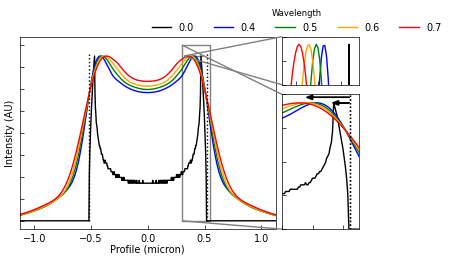

In [21]:
from seaborn import move_legend
def membrane_profile_plot(into_subplot = False, ax = None):
    if not into_subplot:
        fig, ax = plt.subplots(1,1)

    sns.lineplot(x="x axis", y="profile", hue = "Wavelength",
                         data=imshow_data.query("`Imaging Modality` == 'membrane' & `Depth of Focus` == @max_dof_membrane"), palette=wavelength_colours, ax = ax)


    axins1 = inset_axes(ax, 0.5 ,0.5, "lower right") #zoomed_inset_axes(ax, 5, loc="lower center", bbox_to_anchor=(10,-100))

    mark_inset(ax, axins1, loc1=2, loc2=3, fc="none", ec="0.5")
    g = sns.lineplot(x="x axis", y="profile", hue = "Wavelength",
                         data=imshow_data.query("`Imaging Modality` == 'membrane' & `Depth of Focus` == @max_dof_membrane"), palette=wavelength_colours, ax = axins1, legend=None)
    
    move_legend(ax, (0.5,1), ncol=5)
    
    axins1.set_xlim([0.3,0.55])
    axins1.set_ylim([0*10**5, 8*10**5])
    axins1.set_xlabel(None)
    axins1.set_ylabel(None)
    axins1.set_yticklabels([])
    axins1.set_xticklabels([])
    width = imshow_data["True Width"].unique()[0]
    ax.plot([width/2,width/2], [0, 760000], c = "k", linestyle=":")
    
    axins1.plot([width/2,width/2], [0, ax.get_ylim()[1]*1.05], c = "k", linestyle=":")
    ip = InsetPosition(ax,[1.025, 0.0, 0.3, .7])
    axins1.set_axes_locator(ip)
    
    
    ax.set_xlabel("Profile (micron)")


    axins2 = inset_axes(ax, 0.5 , 0.5, "upper left") #zoomed_inset_axes(ax, 5, loc="lower center", bbox_to_anchor=(10,-100))

    ip = InsetPosition(ax,[1.025, 0.75, 0.3, 0.25])
    axins2.set_axes_locator(ip)
    
    mark_inset(ax, axins2, loc1=2, loc2=3,  fc="none", ec="0.5")
    sns.lineplot(x="x axis", y="profile", hue = "Wavelength",
                         data=imshow_data.query("`Imaging Modality` == 'membrane' & `Depth of Focus` == @max_dof_membrane"), palette=wavelength_colours, ax = axins2, legend=None)
    axins2.set_xlim([0.32, 0.49])
    axins2.set_ylim([7.48*10**5, 7.5*10**5])
    axins2.set_xlabel(None)
    axins2.set_ylabel(None)
    axins2.set_yticklabels([])
    axins2.set_xticklabels([])
    ax.plot([-width/2,-width/2], [0, 760000], c = "k", linestyle=":")

    axins1.plot([width/2,width/2], [0, ax.get_ylim()[1]], c = "k", linestyle=":")
    
    ax.set_xlim(ax.get_xlim()[0]*0.5, ax.get_xlim()[1]*0.5)
    ax.set_ylim(ax.get_ylim()[0], ax.get_ylim()[1]*1.05)
    ax.set_ylabel("Intensity (AU)")
    ax.yaxis.set_ticklabels([])
    ax.set_xlabel("Profile (micron)")
    
    axins1.arrow(0.52, 7.495*10**5, -0.035, 0, head_width=27000, head_length=0.02, fc='k', ec='k', width = 0.000001)
    axins1.arrow(0.52, 7.825*10**5, -0.12, 0, head_width=27000, head_length=0.02, fc='k', ec='k', width = 0.000001)

    
    if not into_subplot:
        plt.show()
        
membrane_profile_plot()

In [22]:
estimation_width_data = all_data.groupby(["True Width", "Imaging Modality", "Wavelength"], as_index=False).max("Depth of Focus").query("Wavelength == 0.6")

In [23]:
estimation_width_data = all_data[np.isclose(all_data["Depth of Focus"], all_data["True Width"], rtol=0.05)].query("Wavelength == 0.5")

In [7]:
from matplotlib.pyplot import gcf

In [8]:
import zarr
from skimage.measure import regionprops_table, label

In [9]:
gt_dirs = sorted(glob("projection_analysis_charlie/training_data/*_masks*"))
gt_regionprops = []
for gt_dir in gt_dirs:
    projection, wavelength, _, _ = gt_dir.split("/")[-1].split("_")
    wavelength = float(wavelength)
    properties = pd.DataFrame(regionprops_table(label(np.array(Image.open(gt_dir))), properties = ["area", "minor_axis_length"]))/3 * 0.065
    properties["Projection"] = projection
    properties["Wavelength"] = wavelength
    gt_regionprops.append(properties)
gt_regionprops = pd.concat(gt_regionprops)
gt_regionprops["Mask"] = "Ground truth"

ValueError: No objects to concatenate

In [27]:
human_regionprops = []
charlie_imgs = zarr.open("projection_analysis_charlie/masks/masks.zarr/")
for i, gt_dir in enumerate(gt_dirs):
    projection, wavelength, _, _ = gt_dir.split("/")[-1].split("_")
    wavelength = float(wavelength)
    properties = pd.DataFrame(regionprops_table(label(charlie_imgs[i]) , properties = ["area", "minor_axis_length"])) * 0.065
    properties["Projection"] = projection
    properties["Wavelength"] = wavelength
    human_regionprops.append(properties)
human_regionprops = pd.concat(human_regionprops)
human_regionprops["Mask"] = "Human 1"

human_regionprops_1 = []
erez_imgs = zarr.open("projection_analysis_erez/masks/masks.zarr/")
for i, gt_dir in enumerate(gt_dirs):
    projection, wavelength, _, _ = gt_dir.split("/")[-1].split("_")
    wavelength = float(wavelength)
    properties = pd.DataFrame(regionprops_table(label(erez_imgs[i]) , properties = ["area", "minor_axis_length"])) * 0.065
    properties["Projection"] = projection
    properties["Wavelength"] = wavelength
    human_regionprops_1.append(properties)
human_regionprops_1 = pd.concat(human_regionprops_1)
human_regionprops_1["Mask"] = "Human 2"

In [28]:
all_regionprops = pd.concat([gt_regionprops, human_regionprops, human_regionprops_1])

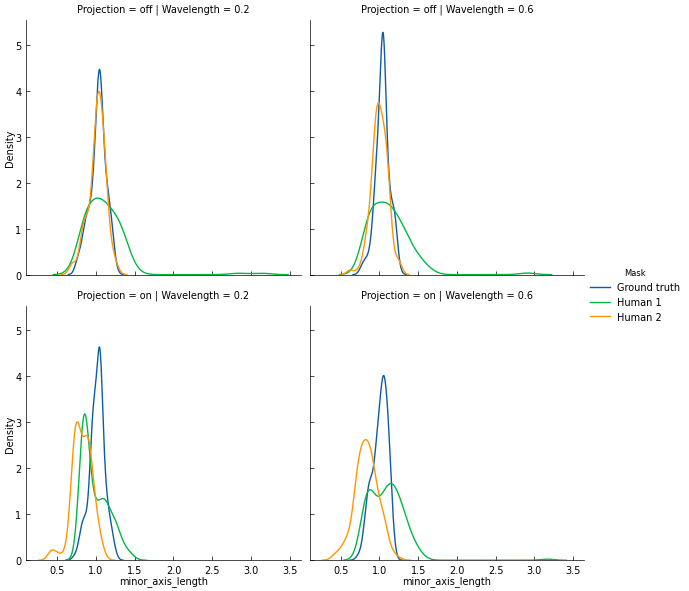

In [29]:
g = sns.FacetGrid(all_regionprops, col="Wavelength",  row="Projection", hue = "Mask")
g.map_dataframe(sns.kdeplot, x="minor_axis_length")
g.add_legend()

In [30]:
all_regionprops.query("Projection == 'off' & Wavelength == 0.2")

,area,minor_axis_length,Projection,Wavelength,Mask
0,78.065000,0.986333,off,0.2,Ground truth
1,78.455000,0.908057,off,0.2,Ground truth
2,70.091667,0.899880,off,0.2,Ground truth
3,140.920000,1.107908,off,0.2,Ground truth
4,97.001667,1.044860,off,0.2,Ground truth
...,...,...,...,...,...
52,50.050000,1.157870,off,0.2,Human 2
53,34.125000,0.963707,off,0.2,Human 2
54,21.450000,0.907411,off,0.2,Human 2
55,34.450000,0.961311,off,0.2,Human 2


In [64]:
all_regionprops["Projection/Wavelength"] = "Proj " +all_regionprops["Projection"] + "\n" + all_regionprops["Wavelength"].astype(str)+ "μm"

Text(0.5, 0, ' ')

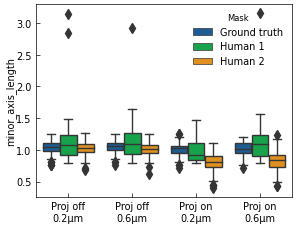

In [66]:
sns.boxplot(data = all_regionprops, y = "minor_axis_length", x = "Projection/Wavelength", hue = "Mask")
plt.xlabel(" ")

In [60]:
all_regionprops["Projection/Wavelength"]

0     Proj off/0.2μm
1     Proj off/0.2μm
2     Proj off/0.2μm
3     Proj off/0.2μm
4     Proj off/0.2μm
           ...      
71     Proj on/0.6μm
72     Proj on/0.6μm
73     Proj on/0.6μm
74     Proj on/0.6μm
75     Proj on/0.6μm
Name: Projection/Wavelength, Length: 1778, dtype: object

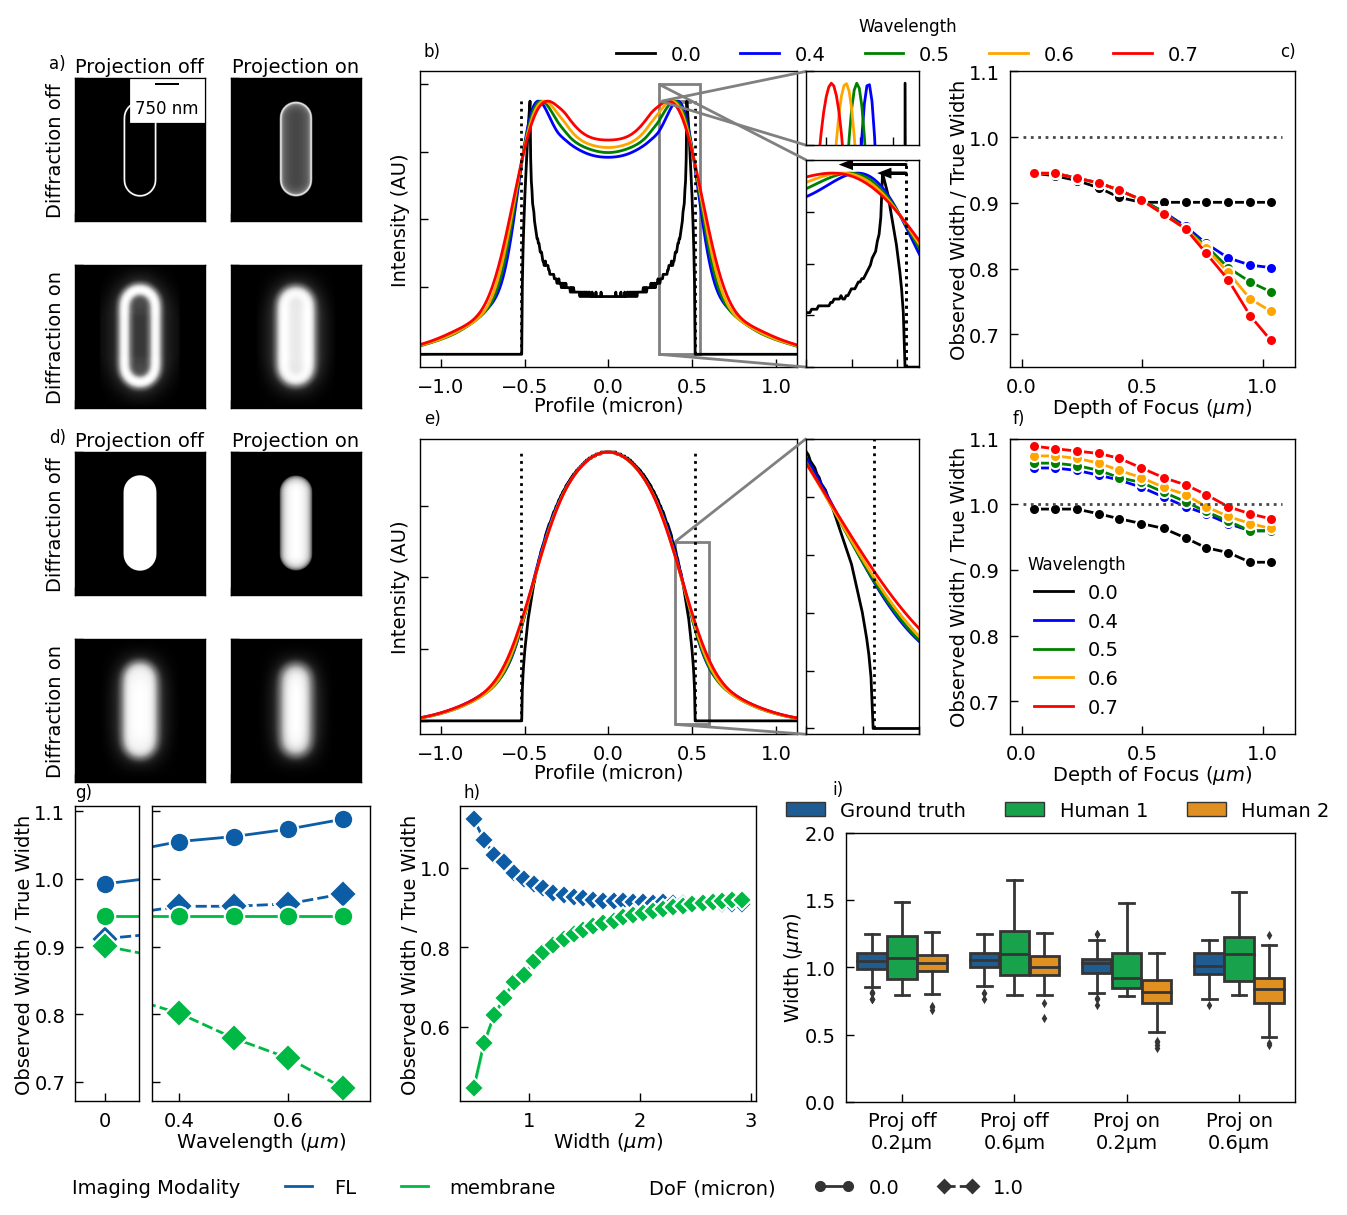

In [117]:
cm = 1/2.54
fig = plt.subplots(figsize = (20*cm,18*cm), dpi = 200)
f = gcf()  # f = figure(n) if you know the figure number
#plt.subplots_adjust(hspace=0.8)

#######
#ROW 1#
#######

mem_00 = plt.subplot2grid((6, 8), (0, 0), colspan=1)
plt.text(-.2, 1.165, 'a)', ha='left', va='top', transform=mem_00.transAxes)

mem_10 = plt.subplot2grid((6, 8), (0, 1), colspan=1)
mem_01 = plt.subplot2grid((6, 8), (1, 0), colspan=1)
mem_11 = plt.subplot2grid((6, 8), (1, 1), colspan=1)
membrane_imshow(True, [mem_00, mem_10, mem_01, mem_11])

membrane_profile_ax = plt.subplot2grid((18, 32), (0, 9), colspan=10, rowspan=5)
membrane_profile_plot(True, membrane_profile_ax)
plt.text(.01, 1.1, 'b)', ha='left', va='top', transform=membrane_profile_ax.transAxes)

membrane_dof_axis = plt.subplot2grid((18, 8), (0, 6), colspan=2, rowspan=5)
plt.text(1, 1.1, 'c)', ha='right', va='top', transform=membrane_dof_axis.transAxes)
sns.lineplot(x="Depth of Focus", y="Observed Width / True Width", hue = "Wavelength",
     data=standard_cell.query("`Imaging Modality` == 'membrane'"), palette=wavelength_colours, marker= "o", markersize=4, legend = None)
plt.xlabel("Depth of Focus ($\mu m$)")
plt.ylim(global_ylims)
plt.plot([membrane_dof_axis.get_xlim()[0],membrane_dof_axis.get_xlim()[1]], [1,1], linestyle =":")

#######
#ROW 2#
#######

FL_profile_ax = plt.subplot2grid((18, 32), (6, 9), colspan=10, rowspan=5)
plt.text(.01, 1.1, 'e)', ha='left', va='top', transform=FL_profile_ax.transAxes)

FL_profile_plot(True, FL_profile_ax)


FL_00 = plt.subplot2grid((6, 8), (2, 0), colspan=1)
plt.text(-.2, 1.165, 'd)', ha='left', va='top', transform=FL_00.transAxes)

FL_10 = plt.subplot2grid((6, 8), (2, 1), colspan=1)
FL_01 = plt.subplot2grid((6, 8), (3, 0), colspan=1)
FL_11 = plt.subplot2grid((6, 8), (3, 1), colspan=1)
FL_imshow(True, [FL_00, FL_10, FL_01, FL_11])



FL_dof_axis = plt.subplot2grid((18, 8), (6, 6), colspan=2, rowspan=5)
sns.lineplot(x="Depth of Focus", y="Observed Width / True Width", hue = "Wavelength",
     data=standard_cell.query("`Imaging Modality` == 'FL'"), palette=wavelength_colours, marker= "o", markersize=4, ax = FL_dof_axis)
plt.xlabel("Depth of Focus ($\mu m$)")
plt.ylim(global_ylims)
plt.plot([FL_dof_axis.get_xlim()[0],FL_dof_axis.get_xlim()[1]], [1,1], linestyle =":")
plt.text(.01, 1.1, 'f)', ha='left', va='top', transform=FL_dof_axis.transAxes)

##########
#ROW 3#
##########


#######
#1#
#######

wavelength_ax = plt.subplot2grid((18, 16), (12, 0), colspan=1, rowspan=5)
p = sns.lineplot(x = "Wavelength", y = "Observed Width / True Width", data = high_low_dof, style = "Depth of Focus", hue = "Imaging Modality", markers = ["o", "D"], markersize=7, ax = wavelength_ax)
plt.legend([])
wavelength_ax.set_xlim(wavelength_ax.get_xlim()[0],0.04)
wavelength_ax.set_xticks([0])
#wavelength_ax.set_yticklabels([0])
plt.xlabel(" ")
plt.text(.01, 1.075, 'g)', ha='left', va='top', transform=wavelength_ax.transAxes)


wavelength_ax_part_2 = plt.subplot2grid((18, 16), (12, 1), colspan=3, rowspan=5)
p = sns.lineplot(x = "Wavelength", y = "Observed Width / True Width", data = high_low_dof, style = "Depth of Focus", hue = "Imaging Modality", markers = ["o", "D"], markersize=7, ax = wavelength_ax_part_2)
leg = p.legend_
for t in leg.texts:
    if any([x in t.get_text() for x in ["Imag", "FL", "memb", "Depth"]]):
        pass
    else:
        t.set_text(t.get_text()[:3])
        
    if "Depth" in t.get_text():
        t.set_text("DoF (micron)")
wavelength_ax_part_2.set_xlim(0.35,0.75)
wavelength_ax_part_2.set_yticklabels([])
wavelength_ax_part_2.set_ylabel("")
move_legend(wavelength_ax_part_2, (-0.65,-0.35), numpoints=2, ncol = 6)
plt.xlabel("Wavelength ($\mu m$)")

#######
#2#
#######

width_ax = plt.subplot2grid((18, 16), (12, 5), colspan=4, rowspan=5)
sns.lineplot(data = estimation_width_data, x = "True Width", y = "Observed Width / True Width", hue = "Imaging Modality", marker="D", markersize=5, legend = None)
plt.xlabel("Width ($\mu m$)")
plt.text(.01, 1.075, 'h)', ha='left', va='top', transform=width_ax.transAxes)

#######
#3#
#######

#annotation_ax_1 = plt.subplot2grid((18, 16), (12, 10), colspan=4, rowspan=2)
#sns.boxplot(data = all_regionprops.query("Wavelength == 0.2"), y = "minor_axis_length", x = "Projection", hue = "Mask", ax = annotation_ax_1,fliersize=1)
#annotation_ax_1.set_ylim(6*0.065,26*0.065)
##annotation_ax_1.legend([])
#move_legend(annotation_ax_1, (1,-0.75))
#annotation_ax_1.set_ylabel("Width (micron)")
#annotation_ax_1.plot(annotation_ax_1.get_xlim(), [1,1], c = "k", linestyle = ":")

#annotation_ax_2 = plt.subplot2grid((18, 16), (15, 10), colspan=4, rowspan=2)
#sns.boxplot(data = all_regionprops.query("Wavelength == 0.6"), y = "minor_axis_length", x = "Projection", hue = "Mask", ax = annotation_ax_2, fliersize=1)
#annotation_ax_2.set_ylim(6*0.065,26*0.065)
#annotation_ax_2.legend([])
#annotation_ax_2.set_ylabel(" ")
#annotation_ax_2.plot(annotation_ax_2.get_xlim(), [1,1], c = "k", linestyle = ":")
#annotation_ax_2.set_ylabel("Width (micron)")

annotation_ax_1 = plt.subplot2grid((18*2, 16), (13*2-1, 10), colspan=8, rowspan=4*2+1)
sns.boxplot(data = all_regionprops, y = "minor_axis_length", x = "Projection/Wavelength", hue = "Mask", ax=annotation_ax_1, fliersize=1)
plt.xlabel(" ")
plt.ylabel("Width ($\mu m$)")
plt.ylim(0, 2)
move_legend(annotation_ax_1, (-.15,1.02), ncol=3, title="")
plt.text(-.03, 1.195, 'i)', ha='left', va='top', transform=annotation_ax_1.transAxes)


plt.savefig("../../figures/fig2.pdf", bbox_inches="tight")
plt.savefig("../../figures/fig2.png", bbox_inches="tight")